## Data Wrangling/Cleaning

In [1]:
#import basic needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#function to provide summary for each column as a dataframe. Thanks to my mentor Ajith Patnaik 
#for providing this code
def univariate_analysis(df):
    """

    :param df: pd.Dataframe containing all the attributes needed
    :return: Dataframe with summary statistics
    """
    df_copy = df.copy()
    row_count = df_copy.shape[0]
    dtype = df_copy.dtypes.reset_index()
    dtype_df= dtype.rename(columns = {'index': 'Column Name', 0: 'Dtype'})
    count_dict, describe_dict = dict(), dict()
    for idx, row in dtype_df.iterrows():
        col_data = df_copy[row['Column Name']]
        null_count = col_data.isnull().sum()
        zero_count = col_data[col_data == 0].shape[0]
        non_zero_count = row_count - null_count - zero_count
        s = df_copy[row['Column Name']].value_counts(dropna = False)
        unique,largest = s.shape[0], s.nlargest(n=1, keep='first')
        top, Freq = largest.index[0], largest.values[0]
        count_dict[row['Column Name']] = {'Non-Zero Count': non_zero_count, 'Null Count': null_count,
                                          'Zero Count': zero_count, 'Unique': unique, 'Top Value': top,
                                          'Top Freq': Freq}
        col_data_noNa = col_data.dropna()
        ser_sum = col_data_noNa.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
        if col_data.dtype != 'object':
            ser_sum = np.round(ser_sum, decimals=4)
        describe_dict[row['Column Name']] = ser_sum.to_dict()
    count_df = pd.DataFrame.from_dict(count_dict, orient='index').reset_index().rename(columns={'index': 'Column Name'})
    describe_df = pd.DataFrame.from_dict(describe_dict, orient='index').reset_index().rename(columns={'index': 'Column Name'})
    if 'top' in describe_df.columns.tolist():
        describe_df = describe_df.drop(['top', 'unique', 'freq'], axis=1)
    merge_df = pd.merge(dtype_df, count_df, on='Column Name')
    final_df = pd.merge(merge_df, describe_df, on='Column Name')
    return final_df

In [3]:
#read in the data

#training data
df=pd.read_csv('lc_loan.csv/lc_loan.csv',low_memory=False)

#test data
df2=pd.read_csv('lc_2016_2017.csv/lc_2016_2017.csv',low_memory=False)

In [4]:
df_stats=univariate_analysis(df)

In [5]:
df_stats.head()

,Column Name,Dtype,Non-Zero Count,Null Count,Zero Count,Unique,Top Value,Top Freq,count,mean,...,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,id,int64,887379,0,0,887379,1077501,1,887379.0,3.246513e+07,...,476445.9,1090262.7,1944971.8,9206643.0,34433267.0,54908135.0,63285441.4,65754792.2,67819908.22,68617057.0
1,member_id,int64,887379,0,0,887379,1296599,1,887379.0,3.500182e+07,...,601782.5,1317185.3,1988500.6,10877133.5,37095283.0,58471347.0,67597478.6,70387497.7,72678208.52,73544841.0
2,loan_amnt,float64,887379,0,0,1372,10000.0,61837,887379.0,1.475526e+04,...,1800.0,3600.0,5000.0,8000.0,13000.0,20000.0,28000.0,32000.0,35000.00,35000.0
3,funded_amnt,float64,887379,0,0,1372,10000.0,61744,887379.0,1.474188e+04,...,1800.0,3600.0,5000.0,8000.0,13000.0,20000.0,27975.0,32000.0,35000.00,35000.0
4,funded_amnt_inv,float64,887146,0,233,9856,10000.0,56111,887379.0,1.470246e+04,...,1600.0,3500.0,5000.0,8000.0,13000.0,20000.0,27800.0,32000.0,35000.00,35000.0


In [6]:
#Write this to an excel file
df_stats.to_excel("dfstats.xlsx")

After writing this to a file we used that information to start an approach to cleaning and feature engineering

In [7]:
#Make new dataframes that we can clean while keeping the old ones in case
#we need something from them deleted initially
train_ids=df['id']
test_ids=df2['id']
#drop ids from test and train data as well as our target loan status
X=df.drop(columns=['id','member_id','loan_status'])
X2=df2.drop(columns=['id','member_id','loan_status'])
#make target columns
y=df['loan_status']
y2=df2['loan_status']

In [8]:
#we can see where the most missing values are in the training data
df_stats.sort_values('Null Count',ascending=False).head(10)

,Column Name,Dtype,Non-Zero Count,Null Count,Zero Count,Unique,Top Value,Top Freq,count,mean,...,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
54,dti_joint,float64,509,886870,0,450,NaN,886870,509.0,18.3101,...,4.0256,7.492,9.558,13.2,17.61,22.65,28.606,31.198,35.4356,43.86
53,annual_inc_joint,float64,511,886868,0,309,NaN,886868,511.0,109981.0116,...,29779.2000,47488.000,56000.000,76032.5,101771.00,132800.00,175000.000,190650.000,270000.0000,500000.00
55,verification_status_joint,object,511,886868,0,4,NaN,886868,511.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,il_util,float64,18479,868762,138,1273,NaN,868762,18617.0,71.5353,...,5.2000,27.800,40.360,58.6,74.90,87.60,96.800,100.700,117.4840,223.30
63,mths_since_rcnt_il,float64,20797,866569,13,202,NaN,866569,20810.0,20.9127,...,1.0000,2.000,3.000,6.0,12.00,23.00,48.000,83.000,134.0000,363.00
59,open_acc_6m,float64,13126,866007,8246,14,NaN,866007,21372.0,1.1090,...,0.0000,0.000,0.000,0.0,1.00,2.00,3.000,3.000,5.0000,14.00
60,open_il_6m,float64,19058,866007,2314,36,NaN,866007,21372.0,2.9288,...,0.0000,0.000,0.000,1.0,2.00,4.00,6.000,9.000,16.0000,40.00
61,open_il_12m,float64,10566,866007,10806,13,NaN,866007,21372.0,0.7617,...,0.0000,0.000,0.000,0.0,0.00,1.00,2.000,3.000,4.0000,12.00
62,open_il_24m,float64,15891,866007,5481,18,NaN,866007,21372.0,1.6746,...,0.0000,0.000,0.000,0.0,1.00,2.00,4.000,5.000,7.0000,19.00
64,total_bal_il,float64,19113,866007,2259,17031,NaN,866007,21372.0,36552.8114,...,0.0000,0.000,0.000,10251.5,24684.50,47858.00,81851.100,113323.300,204248.9300,878459.00


In [9]:
#We can see that there are many missing values related to joint applications
print(X.application_type.value_counts())
print(X2.application_type.value_counts())

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64
Individual    725335
Joint App      34003
Name: application_type, dtype: int64


For now we will focus on individual applications. If we choose to expand to joint applications we will need to figure out how to deal with the features specifically for those that will be null for individuals

In [10]:
#For future potential use we change these so they are the same values in both
X2.application_type.replace({"Individual": "INDIVIDUAL", "Joint App": "JOINT"},inplace=True)
X2.application_type.value_counts()

INDIVIDUAL    725335
JOINT          34003
Name: application_type, dtype: int64

In [11]:
#Remove the joint applications from the test data
X2=X2[X2.application_type=="INDIVIDUAL"]

In [12]:
#We now remove the columns related to joint applications from both
X=X.drop(columns=['application_type','annual_inc_joint','dti_joint','verification_status_joint'])
X2=X2.drop(columns=['application_type','annual_inc_joint','dti_joint','verification_status_joint'])

Issue date, last credit pull date, last payment date ,earliest credit line, next payment date are strings, but will be more useful as datetime objects

In [13]:
X.issue_d=pd.to_datetime(X.issue_d)
X.last_credit_pull_d=pd.to_datetime(X.last_credit_pull_d)
X.last_pymnt_d=pd.to_datetime(X.last_pymnt_d)
X.earliest_cr_line=pd.to_datetime(X.earliest_cr_line)
X2.issue_d=pd.to_datetime(X2.issue_d)
X2.last_credit_pull_d=pd.to_datetime(X2.last_credit_pull_d)
X2.last_pymnt_d=pd.to_datetime(X2.last_pymnt_d)
X2.earliest_cr_line=pd.to_datetime(X2.earliest_cr_line)
X.next_pymnt_d=pd.to_datetime(X.next_pymnt_d)



In [14]:
X2.next_pymnt_d.value_counts()

Jan-2018    560742
Dec-2017       148
Feb-2018        92
Name: next_pymnt_d, dtype: int64

In [15]:
#need to replace the format of dates in the X2 data frame for the next_pymnt_d column before converting to datetime objects
X2.next_pymnt_d.replace({"Jan-2018":"2018-01-01","Dec-2017":"2017-12-01","Feb-2018":"2018-02-01"},inplace=True)
X2.next_pymnt_d=pd.to_datetime(X.next_pymnt_d)

To avoid dependency on issue date as that will change significantly over time we convert to timedeltas

In [16]:
X["last_credit_pull_td"]=X.issue_d-X.last_credit_pull_d
X2["last_credit_pull_td"]=X2.issue_d-X2.last_credit_pull_d
X["last_pymnt_td"]=X.issue_d-X.last_pymnt_d
X2["last_pymnt_td"]=X2.issue_d-X2.last_pymnt_d
X["earliest_cr_line_td"]=X.issue_d-X.earliest_cr_line
X2["earliest_cr_line_td"]=X2.issue_d-X2.earliest_cr_line
X["next_pymnt_td"]=X.issue_d-X.next_pymnt_d
X2["next_pymnt_td"]=X2.issue_d-X2.next_pymnt_d

Now we drop the actual dates from the features

In [17]:
X.drop(columns=["issue_d","last_credit_pull_d","last_pymnt_d","earliest_cr_line","next_pymnt_d"],inplace=True)
X2.drop(columns=["issue_d","last_credit_pull_d","last_pymnt_d","earliest_cr_line","next_pymnt_d"],inplace=True)

We will now convert these to floating point numbers

In [18]:
X["last_credit_pull"]=X.last_credit_pull_td/pd.to_timedelta(1,'D')
X2["last_credit_pull"]=X2.last_credit_pull_td/pd.to_timedelta(1,'D')
X["last_pymnt"]=X.last_pymnt_td/pd.to_timedelta(1,'D')
X2["last_pymnt"]=X.last_pymnt_td/pd.to_timedelta(1,'D')
X["earliest_cr_line"]=X.earliest_cr_line_td/pd.to_timedelta(1,'D')
X2["earliest_cr_line"]=X.earliest_cr_line_td/pd.to_timedelta(1,'D')
X["next_pymnt"]=X.next_pymnt_td/pd.to_timedelta(1,'D')
X2["next_pymnt"]=X2.next_pymnt_td/pd.to_timedelta(1,'D')

We can now get rid of the timedelta features and leave the floating point ones.


In [19]:
X.drop(columns=["last_credit_pull_td","last_pymnt_td","earliest_cr_line_td","next_pymnt_td"],inplace=True)
X2.drop(columns=["last_credit_pull_td","last_pymnt_td","earliest_cr_line_td","next_pymnt_td"],inplace=True)

In [20]:
#drop the url feature
X.drop(columns=["url"],inplace=True)

In [21]:
set(X.columns).difference(set(X2.columns))

{'open_il_6m'}

In [22]:
set(X2.columns).difference(set(X.columns))

set()

In [23]:
#drop the column from the training data that the test data doesn't have
X.drop(columns=['open_il_6m'],inplace=True)

In [24]:
X.term.value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [25]:
X2.term.value_counts()

36 months    541963
60 months    183372
Name: term, dtype: int64

In [26]:
#For now drop 'desc' featire
X.drop(columns=['desc'],inplace=True)
X2.drop(columns=['desc'],inplace=True)

At this point we have the columns we need in place. We will need to impute missing values and see how we want to use categorical data

In [27]:
#For employment will use "other" for missing values
X.emp_title.fillna("other",inplace=True)
X2.emp_title.fillna("other",inplace=True)

Employment length is a bit tricker as it's categorical but we want to have a median to put in for missing values

In [28]:
X.emp_length.value_counts()

10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

In [29]:
#Convert each of these to a numeric value, replacing <1 year with 0 and 10+ with 10
X.emp_length.replace({"10+ years":10,"2 years":2,"< 1 year":0,"3 years":3,"1 year":1,"5 years":5,"4 years":4,"7 years":7,"8 years":8,"6 years":6,"9 years":9},inplace=True)
X.emp_length.value_counts()

10.0    291569
2.0      78870
0.0      70605
3.0      70026
1.0      57095
5.0      55704
4.0      52529
7.0      44594
8.0      43955
6.0      42950
9.0      34657
Name: emp_length, dtype: int64

In [30]:
X2.emp_length.value_counts()

10+ years    250318
2 years       67361
3 years       58973
< 1 year      52167
1 year        49149
5 years       44679
4 years       44165
6 years       31652
8 years       27881
9 years       27709
7 years       25019
Name: emp_length, dtype: int64

In [31]:
#we will do the same with the test data
X2.emp_length.replace({"10+ years":10,"2 years":2,"< 1 year":0,"3 years":3,"1 year":1,"5 years":5,"4 years":4,"7 years":7,"8 years":8,"6 years":6,"9 years":9},inplace=True)
X2.emp_length.value_counts()

10.0    250318
2.0      67361
3.0      58973
0.0      52167
1.0      49149
5.0      44679
4.0      44165
6.0      31652
8.0      27881
9.0      27709
7.0      25019
Name: emp_length, dtype: int64

In [32]:
#We will use the median of the test data to impute. 
X.emp_length.median()

6.0

In [33]:
X.emp_length.fillna(6,inplace=True)
X2.emp_length.fillna(6,inplace=True)

In [34]:
X.annual_inc.describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

In [35]:
X.annual_inc.median()

65000.0

In [36]:
X.annual_inc.fillna(65000,inplace=True)
X2.annual_inc.fillna(65000,inplace=True)

In [37]:
X.title.value_counts()

Debt consolidation                     414001
Credit card refinancing                164331
Home improvement                        40112
Other                                   31892
Debt Consolidation                      15760
                                        ...  
New Heater                                  1
Looking to get out of debt                  1
Debt Conso/Pay off initial LC loan          1
Emergency Home Repair                       1
Credit Card/Auto Repair                     1
Name: title, Length: 63144, dtype: int64

In [38]:
X.purpose.value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [39]:
X.title.isna().sum()

152

In [40]:
X.purpose.isna().sum()

0

In [41]:
X2.title.isna().sum()

22316

In [42]:
X2.purpose.isna().sum()

0

In [43]:
#For title we use 'other' for missing values
X.title.fillna("other",inplace=True)
X2.title.fillna("other",inplace=True)

For entries about negative events in a time period we will fill those with 0, assuming that no information means those events did not occur

In [44]:
X.inq_last_6mths.fillna(0,inplace=True)
X.inq_last_12m.fillna(0,inplace=True)
X.inq_fi.fillna(0,inplace=True)
X.collections_12_mths_ex_med.fillna(0,inplace=True)
X.pub_rec.fillna(0,inplace=True)
X.acc_now_delinq.fillna(0,inplace=True)
X.delinq_2yrs.fillna(0,inplace=True)


In [45]:
X2.inq_last_6mths.fillna(0,inplace=True)
X2.inq_last_12m.fillna(0,inplace=True)
X2.inq_fi.fillna(0,inplace=True)
X2.collections_12_mths_ex_med.fillna(0,inplace=True)
X2.pub_rec.fillna(0,inplace=True)
X2.acc_now_delinq.fillna(0,inplace=True)
X2.delinq_2yrs.fillna(0,inplace=True)


In [46]:
X.all_util.describe()

count    21372.000000
mean        60.831939
std         20.013254
min          0.000000
25%         47.700000
50%         61.900000
75%         75.200000
max        151.400000
Name: all_util, dtype: float64

In [47]:
X.all_util.value_counts()

61.0     71
68.0     60
51.0     57
61.3     57
72.0     56
         ..
3.3       1
15.7      1
107.9     1
97.6      1
7.4       1
Name: all_util, Length: 1128, dtype: int64

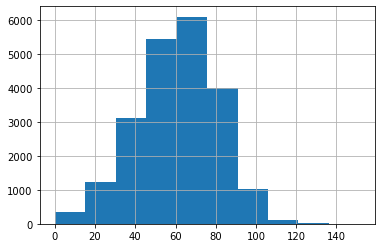

In [48]:
X.all_util.hist()
plt.show()

In [49]:
X.all_util.isna().sum()

866007

The distribution of utilization number is centered around 62%, however the vast majority have nothing put in, so this is a very small amount to generalize from. We might have to dig a little deeper to see if we can figure out what is going on

In [62]:
X.tot_cur_bal.describe()

count    8.171030e+05
mean     1.394582e+05
std      1.537500e+05
min      0.000000e+00
25%      2.985300e+04
50%      8.055900e+04
75%      2.082050e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

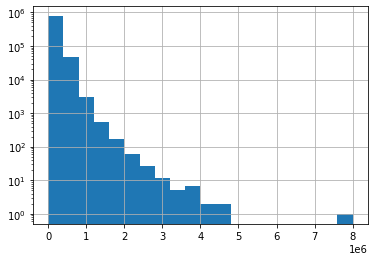

In [54]:
X.tot_cur_bal.hist(bins=
plt.yscale("log")
plt.show()